Fork from https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner/notebook

# Predicting the winner of the 2018 FIFA World Cup
**Aim**: 
to predict the outcome of the FIFA World Cup 2018

 **Method**:
- Use data from Kaggle to model the outcome of certain pairings between teams, given their rank, points, and the weighted point difference with the opponent.
- Use this model to predict the outcome of the group rounds and then the single-elimination phase

**Summary**
According to the analysis below, the team that will win the World Cup is the [underdog according to the bookies](https://www.oddschecker.com/football/world-cup/winner): Germany . But this is not the only interesting thing you can observe. If [not interested in the data munging part](https://ih1.redbubble.net/image.441592463.7099/sticker,375x360-bg,ffffff.u1.png) head to the last section (Visualization) and see the single-elimination phase. To make the story more interesting for the sport lovers, I report fair odds (i.e. fair market, without bookmaker margin) instead of the raw probability output. 

Couple things to note, 
- it seems Egypt qualifies to the best 16 and their match with Portugal is the safest bet in the phase. 
- In this simulation, Brasil cannot make it through Belgium.. I'm sure here many would consider otherwise
- It seems that neither CRonaldo (POR) nor LMessi (ARG) is going to play in the final but they are going to play against each other in the quarterfinals...

All in all, I'm looking forward to the tournament! Place your bets and get ready you too! 

Cheers!

# Data I/O

I use three datasets
- FIFA rankings from 1993 to 2018 (courtesy of [Tadhg Fitzgerald](https://www.kaggle.com/tadhgfitzgerald) 
> This one I used to get the FIFA ranking and points for the teams, which is a monthly changing rank previously shown as a [decent predictor](http://www.sportingintelligence.com/2014/06/20/upsets-giant-killings-adios-bye-bye-fifa-rankings-still-ahead-in-predicting-results-200601/) of team performance
- International Soccer matches from 1872 to 2018 (courtesy of [Mart Jürisoo](https://www.kaggle.com/martj42))
> This I will use to find out how much the difference in point, ranks and the current rank of the team affects the outocme of a match
- FIFA World Cup 2018 data set (courtesy of [Nuggs](https://www.kaggle.com/ahmedelnaggar))
> This I will use to get the upcoming matches 

Comment: Right when reading the datafiles I take care of the renaming of the Countries because there is some mismatch in the sources

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

rankings = pd.read_csv('../input/fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('../input/results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

world_cup = pd.read_csv('../input/World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')

temperatures = pd.read_csv('../input/GlobalLandTemperaturesByCountry.csv')
temperatures = temperatures[(temperatures['dt'] > '1900-01-01')]
temperatures = temperatures[['AverageTemperature', 'Country']]
temperatures = temperatures.groupby('Country').mean().reset_index()

In [2]:
temperatures = temperatures.append({'Country': 'England',
                                    'AverageTemperature': temperatures[temperatures['Country'] == 'United Kingdom']['AverageTemperature'].values[0]
                                   }, ignore_index=True)
temperatures = temperatures.append({'Country': 'Korea Republic',
                                    'AverageTemperature': temperatures[temperatures['Country'] == 'South Korea']['AverageTemperature'].values[0]
                                   }, ignore_index=True)
temperatures.tail()

,Country,AverageTemperature
240,Zambia,21.399332
241,Zimbabwe,21.246273
242,Åland,5.667528
243,England,8.773494
244,Korea Republic,12.071817


In [3]:
rankings.head()

,rank,country_full,country_abrv,cur_year_avg_weighted,rank_date,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,1,Germany,GER,0.0,1993-08-08,0.0,0.0,0.0
1,2,Italy,ITA,0.0,1993-08-08,0.0,0.0,0.0
2,3,Switzerland,SUI,0.0,1993-08-08,0.0,0.0,0.0
3,4,Sweden,SWE,0.0,1993-08-08,0.0,0.0,0.0
4,5,Argentina,ARG,0.0,1993-08-08,0.0,0.0,0.0


In [4]:
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [5]:
world_cup.head()

,Group,First match against,Second match against,Third match against
Team,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay
Saudi Arabia,A,Russia,Uruguay,Egypt
Egypt,A,Uruguay,Russia,Saudi Arabia
Uruguay,A,Egypt,Saudi Arabia,Russia
Portugal,B,Spain,Morocco,Iran


# Feature extraction

I join the matches with the ranks of the different teams. 

Then extract some features:
- point and rank differences
- if the game was for some stakes, because my naive view was that typically friendly matches are harder to predict (TODO differentiate the WC matches from the rest)
- how many days the different teams were able to rest but this turned out to be not important enough to be worth the hassle
- include the participant countries as a one hot vector but that did not appear to be a strong predictor either

In [6]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [7]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = (matches['tournament'] != 'Friendly').astype(int)

# I tried earlier rest days but it did not turn to be useful
max_rest = 30
matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# I tried earlier the team as well but that did not make a difference either
matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
matches = matches.join(pd.get_dummies(matches['wc_participant']))

In [8]:
matches = matches.merge(temperatures,
                        left_on=['home_team'],
                        right_on=['Country'],
                        suffixes=('_country', '_home'))

matches = matches.merge(temperatures,
                        left_on=['away_team'],
                        right_on=['Country'],
                        suffixes=('_home', '_away'))

matches = matches.merge(temperatures,
                        left_on=['country'],
                        right_on=['Country'],
                        suffixes=('_away', '_country'))

matches['temperature_difference_home'] = matches['AverageTemperature'] - matches['AverageTemperature_home']
matches['temperature_difference_away'] = matches['AverageTemperature'] - matches['AverageTemperature_away']

# Modeling

I used a simple Logistic regression, which yielded already rather good performance

In [9]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# X, y = matches.loc[:,['rank_home', 'cur_year_avg_weighted_home', 'two_year_ago_weighted_home',
#                       'three_year_ago_weighted_home', 'weighted_points_home',
#                       'rank_away', 'cur_year_avg_weighted_away', 'two_year_ago_weighted_away',
#                       'three_year_ago_weighted_away', 'weighted_points_away',
#                       'rest_days', 'is_stake', 'temperature_difference_home', 'temperature_difference_away'
#                      ]], matches['is_won']
X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference',
                      'is_stake', 'temperature_difference_home', 'temperature_difference_away'
                     ]], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X.tail()

,average_rank,rank_difference,point_difference,is_stake,temperature_difference_home,temperature_difference_away
15245,181.5,-41.0,0.00,0,0.0,-0.274392
15246,181.5,-41.0,0.00,0,0.0,-0.274392
15247,179.0,-34.0,0.00,0,0.0,-0.274392
15248,200.5,-3.0,0.00,0,0.0,-0.274392
15249,165.5,13.0,-26.47,1,0.0,-0.970836


In [10]:
def prepare_X_for_keras(X):
    X_keras = X.copy()
    X_keras = X_keras.values.astype(np.float32, copy=False)
    return X_keras

X_keras = prepare_X_for_keras(X)
X_keras

array([[  40.5       ,   37.        ,    0.        ,    1.        ,
           0.        ,    3.67053914],
       [  42.5       ,  -17.        ,    0.        ,    1.        ,
           0.        ,    3.67053914],
       [  31.        ,  -26.        ,    0.        ,    1.        ,
           0.        ,    3.67053914],
       ..., 
       [ 179.        ,  -34.        ,    0.        ,    0.        ,
           0.        ,   -0.27439237],
       [ 200.5       ,   -3.        ,    0.        ,    0.        ,
           0.        ,   -0.27439237],
       [ 165.5       ,   13.        ,  -26.46999931,    1.        ,
           0.        ,   -0.97083569]], dtype=float32)

In [11]:
def prepare_y_for_keras(y):
    y_keras = y.copy()
    y_keras = pd.get_dummies(y_keras).values
    
    return y_keras

y_keras = prepare_y_for_keras(y)
y_keras

array([[0, 1],
       [0, 1],
       [0, 1],
       ..., 
       [0, 1],
       [0, 1],
       [1, 0]], dtype=uint8)

In [464]:
import plaidml.keras
plaidml.keras.install_backend()

In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(
    X_keras, y_keras, test_size=0.2, random_state=42)

Using TensorFlow backend.


In [469]:
model = Sequential()
model.add(Dense(4, activation='relu', input_dim=len(X.columns)))
# model.add(Dropout(0.2))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(16, activation="tanh", input_dim=len(X.columns)))
model.add(Dense(8, activation="sigmoid"))
model.add(Dense(2, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor='acc', patience=1, mode='max')
model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=1, callbacks=[early_stop])

loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print("Accuracy = {:.2f}".format(accuracy))

Epoch 1/5
12200/12200 [==============================] - 63s - loss: 0.6197 - acc: 0.6586    
Epoch 2/5
12200/12200 [==============================] - 64s - loss: 0.6096 - acc: 0.6668    
Epoch 3/5
12200/12200 [==============================] - 64s - loss: 0.6053 - acc: 0.6708    
Epoch 4/5
12200/12200 [==============================] - 63s - loss: 0.6036 - acc: 0.6712    
Epoch 5/5
3008/3050 [============================>.] - ETA: 0sAccuracy = 0.68


In [14]:
from keras.models import load_model

# model.save('model.h5')

model = load_model('model.h5')

model

accuracy 0.675409836066
confusion_matrix
 [[1119  480]
 [ 510  941]]
f1_score 0.655292479109


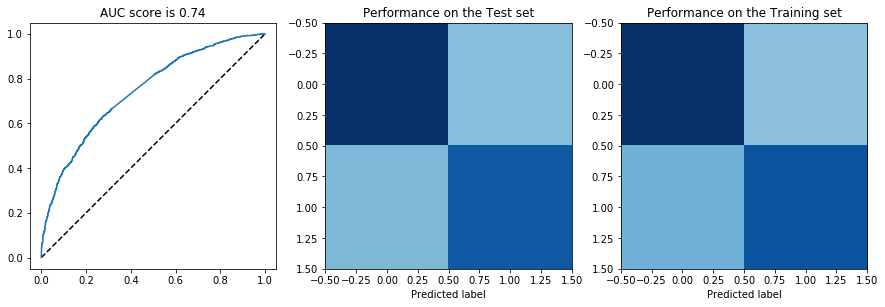

In [15]:
# figures 

y_test_ = y_test[:,1]
predictions = list(map(round, model.predict(X_test)[:,1]))
predictions_proba = model.predict(X_test)[:,1]

y_train_ = y_train[:,1]
predictions_train = list(map(round, model.predict(X_train)[:,1]))

fpr, tpr, _ = roc_curve(y_test_, predictions_proba)
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test_, predictions_proba)))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test_, predictions)
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train_, predictions_train)
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')

print("accuracy", accuracy_score(y_test_, predictions))
print("confusion_matrix\n", confusion_matrix(y_test_, predictions))
print("f1_score", f1_score(y_test_, predictions))

I consider this pretty good performance, minding that soccer matches have typically only few goals scored and therefore making their outcome even more unpredictable. Nevertheless, let's look at the bad predictions and see where we are making mistakes more often.

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

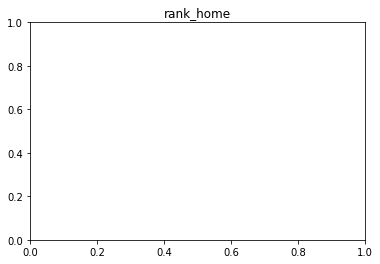

In [443]:
features = ['rank_home', 'rank_difference', 'point_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

From these figures, we read 
- we predict worse for closer ranks
- lower ranks in general
- and somewhat for matches with no stakes (Friendly here)

Luckily, this implies that for the world cup our predicitons may be somewhat even better

# World Cup simulation

## Group rounds

In [19]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [20]:
russia_temp = temperatures[temperatures['Country'] == 'Russia']['AverageTemperature'].values[0]
russia_temp

-5.1496434336023444

In [21]:
# Results the model got wrong and we fix it mannually
known_results = {
    'Russia-Saudi Arabia': 'Russia',
    'Egypt-Uruguay': 'Uruguay',
    'Morocco-Iran': 'Iran',
    'Costa Rica-Serbia': 'Serbia',
    'Germany-Mexico': 'Mexico'
}
known_results

{'Russia-Saudi Arabia': 'Russia',
 'Egypt-Uruguay': 'Uruguay',
 'Morocco-Iran': 'Iran',
 'Costa Rica-Serbia': 'Serbia',
 'Germany-Mexico': 'Mexico'}

In [22]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

def create_match(home, away):
    row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True, np.nan, np.nan]]), columns=X.columns)
    home_rank = world_cup_rankings.loc[home, 'rank']
    home_points = world_cup_rankings.loc[home, 'weighted_points']
    opp_rank = world_cup_rankings.loc[away, 'rank']
    opp_points = world_cup_rankings.loc[away, 'weighted_points']
    row['average_rank'] = (home_rank + opp_rank) / 2
    row['rank_difference'] = home_rank - opp_rank
    row['point_difference'] = home_points - opp_points

    home_temp = temperatures[temperatures['Country'] == home]['AverageTemperature'].values
    if len(home_temp) > 0:
        row['temperature_difference_home'] = russia_temp - home_temp[0]

    away_temp = temperatures[temperatures['Country'] == away]['AverageTemperature'].values
    if len(away_temp) > 0:
        row['temperature_difference_away'] = russia_temp - away_temp[0]
        
    return row

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = create_match(home, away)
            
        known_result = known_results.get(home + '-' + away, None)
        if (known_result == home):
            home_win_prob = 1
        elif (known_result == away):
            home_win_prob = 0
        elif (known_result == 'Draw'):
            home_win_prob = 0.5
        else:
            home_win_prob = model.predict(prepare_X_for_keras(row))[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw with", home_win_prob)
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group G:___
Belgium vs. Panama: Belgium wins with 0.75
Belgium vs. Tunisia: Belgium wins with 0.58
Belgium vs. England: Draw with 0.471715
Panama vs. Tunisia: Tunisia wins with 0.76
Panama vs. England: England wins with 0.76
Tunisia vs. England: England wins with 0.58
___Starting group D:___
Argentina vs. Iceland: Draw with 0.532632
Argentina vs. Croatia: Draw with 0.523556
Argentina vs. Nigeria: Argentina wins with 0.71
Iceland vs. Croatia: Draw with 0.46422
Iceland vs. Nigeria: Iceland wins with 0.66
Croatia vs. Nigeria: Croatia wins with 0.65
___Starting group C:___
France vs. Australia: France wins with 0.65
France vs. Peru: Draw with 0.46422
France vs. Denmark: Draw with 0.482078
Australia vs. Peru: Peru wins with 0.76
Australia vs. Denmark: Denmark wins with 0.76
Peru vs. Denmark: Denmark wins with 0.66
___Starting group A:___
Russia vs. Saudi Arabia: Russia wins with 1.00
Russia vs. Egypt: Draw with 0.46422
Russia vs. Uruguay: Uruguay wins with 0.76
Saudi Arabia vs. 

## Single-elimination rounds

In [23]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = create_match(home, away)

        home_win_prob = model.predict(prepare_X_for_keras(row))[:,1][0]
        if home_win_prob <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Portugal: Portugal wins with probability 0.76
Denmark vs. Croatia: Croatia wins with probability 0.60
Switzerland vs. Germany: Germany wins with probability 0.76
England vs. Colombia: Colombia wins with probability 0.53
Russia vs. Spain: Spain wins with probability 0.76
France vs. Argentina: Argentina wins with probability 0.67
Brazil vs. Mexico: Mexico wins with probability 0.54
Belgium vs. Poland: Poland wins with probability 0.54


___Starting of the quarterfinal___
Portugal vs. Croatia: Portugal wins with probability 0.51
Germany vs. Colombia: Germany wins with probability 0.53
Spain vs. Argentina: Argentina wins with probability 0.63
Mexico vs. Poland: Poland wins with probability 0.55


___Starting of the semifinal___
Portugal vs. Germany: Germany wins with probability 0.76
Argentina vs. Poland: Poland wins with probability 0.54


___Starting of the final___
Germany vs. Poland: Poland wins with probability 0.54




# Let's see a visualization 

/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


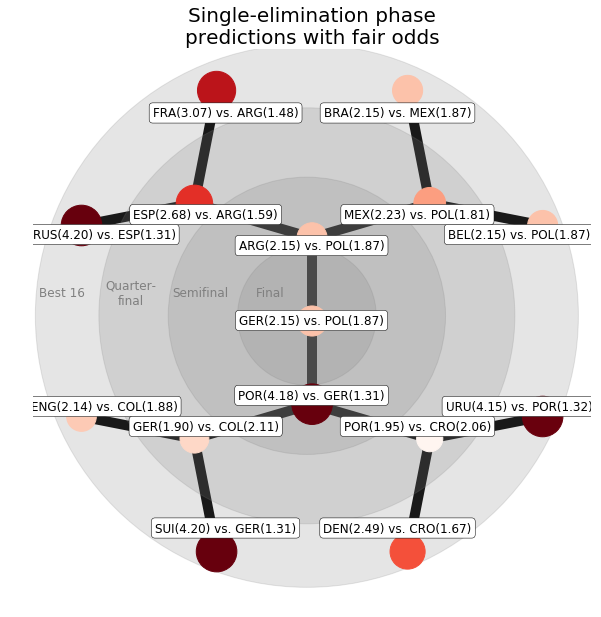

In [24]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi', args='')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()

Fin